In [ ]:
#####NOTE: this notebook uses the tuning results from "OpenBCI data - CNN Tuning.ipynb"

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from scipy import signal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Lambda, AveragePooling2D, Softmax, ReLU, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
from math import floor,inf
from sklearn.utils import shuffle
import seaborn as sns
import keras_tuner as kt

In [2]:
###Enter tasks to be classified as a list e.g. left hand and right hand MI
labels = ['Left Hand', 'Right Hand']

In [3]:
###Maps labels to numbers starting from 0
def map_labels(label):
    for i in range(len(labels)):
        if label == labels[i]:
            label = i
    return label

In [4]:
###Function to process raw EEG and create training and validation datasets
def create_data(data_folder, filtered, samples, overlap, classes):
    b,a = signal.butter(2, Wn = [48,52], btype = 'bandstop', fs = 250)
    d,c = signal.butter(2, Wn = [4,38], btype = 'bandpass', fs = 250)
    
    data_dir = os.path.join(os.getcwd(),data_folder)

    mi_tasks=classes
    
    directories = {}
    for i in range(len(mi_tasks)):
        directories[mi_tasks[i]] = data_dir + '\\' + mi_tasks[i]

    samples = samples
    overlap = overlap
    unique = floor((1-overlap)*samples)
    x=[]
    y=[]
    all_data = {}
    filtered_data = {}

    for task in mi_tasks:
        all_data[task] = {}
        filtered_data[task] = {}    

    for i in directories:
        folders = os.listdir(directories[i])
        count = 0
        for w in range(len(folders)):
            current_dir = directories[i] + '\\' + folders[w]
            files = os.listdir(current_dir)
            for file in files:
                data = pd.read_csv(current_dir + '\\' + file, header = None)
                eeg_data = data.iloc[1:,1:9]
                if eeg_data.size >= 3250: #rejects trials with recording errors that were short
                    for div in range(int(eeg_data.size//(eeg_data.shape[1]*unique))):
                        if div*unique +samples <= eeg_data.size/eeg_data.shape[1]:
                            all_data[i][count]= eeg_data[div*unique:div*unique + samples]
                            if filtered:
                                to_filter = all_data[i][count]
                                filtered_data=pd.DataFrame(columns = range(0,eeg_data.shape[1]))
                                for chan in range(to_filter.shape[1]):
                                    notch_filtered_chan = signal.filtfilt(b,a,to_filter.iloc[:,chan], padtype='even')
                                    filtered_chan = signal.filtfilt(d,c,notch_filtered_chan, padtype='even')
                                    filtered_data[chan] = filtered_chan
                                x.append(np.transpose(filtered_data.to_numpy()))
                                    
                            else:
                                x.append(np.transpose(all_data[i][count].to_numpy()))
                            
                            y.append(i)
                            count += 1

                else:
                    print('* not accepted *')   #for trials that were too short
                    print(file)
    x=np.array(x)
    x=x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
    y = list(map(map_labels,y))
    x, y = shuffle(x,y, random_state=42)
    return all_data, x, y

In [5]:
###Location of raw EEG trials
train_data_folder = '05to20-08 Active 8chan FPZ Bias'
test_data_folder = '23&24-08 Active 8chan FPZ Bias'

In [6]:
###Create filtered 2 sec trials with 90% overlap
train_data, x_train, y_train = create_data(train_data_folder, True, 500, 0.90, labels)
test_data, x_test, y_test = create_data(test_data_folder, True, 500, 0.90, labels)
print(x_train.shape)
print(x_test.shape)

(4336, 8, 500, 1)
(1441, 8, 500, 1)


In [8]:
###Class labels one-hot encoded
y_cat_train = to_categorical(y_train)
y_cat_test = to_categorical(y_test)

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

In [10]:
####  Must define model and hyperparamters used for tuning before saved tuner results can be loaded
def build_model(hp):
    model = Sequential()
    
    hp_filters = hp.Int('Filters', min_value=10,max_value=160,step=10)
    hp_kern_len = hp.Int('Kernel1 Length', min_value=10, max_value=250, step=10)
    model.add(Conv2D(filters=hp_filters, kernel_size=(1,hp_kern_len), input_shape=(x_train.shape[1],x_train.shape[2],1))) #, activation = 'relu'))
    model.add(Conv2D(filters=hp_filters, kernel_size=(8,1), activation = 'elu'))
    hp_momentum = hp.Float('Momentum', min_value=0.05, max_value=0.95, step=0.05)
    model.add(BatchNormalization(momentum=hp_momentum, epsilon = 1e-05))
    model.add(Lambda(lambda x: x**2))
    hp_pool_len = hp.Int('Pooling Length', min_value=10, max_value=250, step=10)
    hp_strides = hp.Int('Pooling Strides', min_value = 5, max_value=50, step=5)
    model.add(AveragePooling2D(pool_size=(1,hp_pool_len),strides=hp_strides))
    
    model.add(Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 1e-6, inf))))
    hp_dropout = hp.Float('Dropout Rate', min_value=0.1, max_value=0.9, step = 0.1)
    model.add(Dropout(hp_dropout))
    
    '''model.add(Conv2D(filters=4, kernel_size=(1,69))) #, activation = 'relu'))       
    
    model.add(Softmax())
    
    model.add(Lambda(lambda x: tf.squeeze(x, [1,2])))'''
    
    model.add(Flatten())

    model.add(Dense(len(labels), activation = 'sigmoid'))  #sigmoid for binary classification
    
    #act_fn = 'softmax'  #for multi-class classification
    loss_fn = 'binary_crossentropy'  #for binary classification (categorical crossentropy for multi-class)
    
    hp_learn_rate = hp.Choice('Learning Rate', values=[1e-1,1e-2,1e-3,1e-4,1e-5,1e-6])
    
    
    adam = tf.keras.optimizers.Adam(learning_rate=hp_learn_rate)
    model.compile(loss = loss_fn, optimizer=adam, metrics=['accuracy'], )  # other metrics at keras.io/metrics
    return model

In [11]:
###Reload tuner from saved folder
tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 500,
                     factor = 3,
                     directory=os.getcwd(),
                     project_name = 'TunedCNN-2classLHRH MI-ACTIVE 8chan')

INFO:tensorflow:Reloading Oracle from existing project C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-2classLHRH MI-ACTIVE 8chan\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-2classLHRH MI-ACTIVE 8chan\tuner0.json


In [12]:
tuner.results_summary()

Results summary
Results in C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-2classLHRH MI-ACTIVE 8chan
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
Filters: 150
Kernel1 Length: 90
Momentum: 0.05
Pooling Length: 130
Pooling Strides: 40
Dropout Rate: 0.30000000000000004
Learning Rate: 0.001
tuner/epochs: 19
tuner/initial_epoch: 7
tuner/bracket: 5
tuner/round: 2
tuner/trial_id: dfec56c6e03de71d17aee6a27cd0781d
Score: 0.6044413447380066
Trial summary
Hyperparameters:
Filters: 80
Kernel1 Length: 70
Momentum: 0.2
Pooling Length: 190
Pooling Strides: 35
Dropout Rate: 0.6
Learning Rate: 0.001
tuner/epochs: 19
tuner/initial_epoch: 7
tuner/bracket: 4
tuner/round: 1
tuner/trial_id: a408ba021de35fc9c8e0a9683eef2df9
Score: 0.6044413447380066
Trial summary
Hyperparameters:
Filters: 90
Kernel1 Length: 80
Momentum: 0.55
Pooling Length: 220
Pooling Strides: 20
Dropout Rate: 0.4
Learning Rate: 0.0001
tuner/epochs: 

In [13]:
#get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 8, 411, 150)       13650     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 1, 411, 150)       180150    
_________________________________________________________________
batch_normalization_31 (Batc (None, 1, 411, 150)       600       
_________________________________________________________________
lambda_62 (Lambda)           (None, 1, 411, 150)       0         
_________________________________________________________________
average_pooling2d_31 (Averag (None, 1, 8, 150)         0         
_________________________________________________________________
lambda_63 (Lambda)           (None, 1, 8, 150)         0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 1, 8, 150)       

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



[[376 345]
 [268 452]]
46/46 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.5746
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 8, 411, 150)       13650     
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 1, 411, 150)       180150    
_________________________________________________________________
batch_normalization_32 (Batc (None, 1, 411, 150)       600       
_________________________________________________________________
lambda_64 (Lambda)           (None, 1, 411, 150)       0         
_________________________________________________________________
average_pooling2d_32 (Averag (None, 1, 8, 150)         0         
_________________________________________________________________
lambda_65 (Lambda)           (None, 1, 8, 150)         0         
________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



[[407 314]
 [309 411]]
46/46 [==============================] - 0s 4ms/step - loss: 0.7009 - accuracy: 0.5677
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 8, 411, 150)       13650     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 1, 411, 150)       180150    
_________________________________________________________________
batch_normalization_33 (Batc (None, 1, 411, 150)       600       
_________________________________________________________________
lambda_66 (Lambda)           (None, 1, 411, 150)       0         
_________________________________________________________________
average_pooling2d_33 (Averag (None, 1, 8, 150)         0         
_________________________________________________________________
lambda_67 (Lambda)           (None, 1, 8, 150)         0         
________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[479 242]
 [357 363]]
46/46 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5843
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 8, 411, 150)       13650     
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 1, 411, 150)       180150    
_________________________________________________________________
batch_normalization_34 (Batc (None, 1, 411, 150)       600       
_________________________________________________________________
lambda_68 (Lambda)           (None, 1, 411, 150)       0         
_________________________________________________________________
average_pooling2d_34 (Averag (None, 1, 8, 150)         0         
_________________________________________________________________
lambda_69 (Lambda)           (None, 1, 8, 150)         0         
_________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5455
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 8, 411, 150)       13650     
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 1, 411, 150)       180150    
_________________________________________________________________
batch_normalization_35 (Batc (None, 1, 411, 150)       600       
_________________________________________________________________
lambda_70 (Lambda)           (None, 1, 411, 150)       0         
_________________________________________________________________
average_pooling2d_35 (Averag (None, 1, 8, 150)         0         
_________________________________________________________________
lambda_71 (Lambda)           (None, 1, 8, 150)         0         
________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



[[515 206]
 [418 302]]
46/46 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5670
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 8, 411, 150)       13650     
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 1, 411, 150)       180150    
_________________________________________________________________
batch_normalization_36 (Batc (None, 1, 411, 150)       600       
_________________________________________________________________
lambda_72 (Lambda)           (None, 1, 411, 150)       0         
_________________________________________________________________
average_pooling2d_36 (Averag (None, 1, 8, 150)         0         
_________________________________________________________________
lambda_73 (Lambda)           (None, 1, 8, 150)         0         
________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



[[406 315]
 [316 404]]
46/46 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5621
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 8, 411, 150)       13650     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 1, 411, 150)       180150    
_________________________________________________________________
batch_normalization_37 (Batc (None, 1, 411, 150)       600       
_________________________________________________________________
lambda_74 (Lambda)           (None, 1, 411, 150)       0         
_________________________________________________________________
average_pooling2d_37 (Averag (None, 1, 8, 150)         0         
_________________________________________________________________
lambda_75 (Lambda)           (None, 1, 8, 150)         0         
________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5573
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 8, 411, 150)       13650     
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 1, 411, 150)       180150    
_________________________________________________________________
batch_normalization_38 (Batc (None, 1, 411, 150)       600       
_________________________________________________________________
lambda_76 (Lambda)           (None, 1, 411, 150)       0         
_________________________________________________________________
average_pooling2d_38 (Averag (None, 1, 8, 150)         0         
_________________________________________________________________
lambda_77 (Lambda)           (None, 1, 8, 150)         0         
________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



[[540 181]
 [439 281]]
46/46 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5697
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 8, 411, 150)       13650     
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 1, 411, 150)       180150    
_________________________________________________________________
batch_normalization_39 (Batc (None, 1, 411, 150)       600       
_________________________________________________________________
lambda_78 (Lambda)           (None, 1, 411, 150)       0         
_________________________________________________________________
average_pooling2d_39 (Averag (None, 1, 8, 150)         0         
_________________________________________________________________
lambda_79 (Lambda)           (None, 1, 8, 150)         0         
________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5975
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 8, 411, 150)       13650     
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 1, 411, 150)       180150    
_________________________________________________________________
batch_normalization_40 (Batc (None, 1, 411, 150)       600       
_________________________________________________________________
lambda_80 (Lambda)           (None, 1, 411, 150)       0         
_________________________________________________________________
average_pooling2d_40 (Averag (None, 1, 8, 150)         0         
_________________________________________________________________
lambda_81 (Lambda)           (None, 1, 8, 150)         0         
________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



[[479 242]
 [364 356]]
46/46 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5795


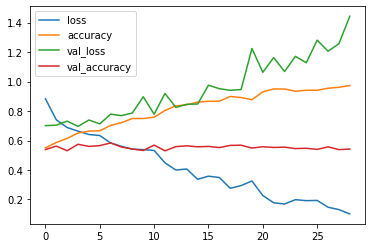

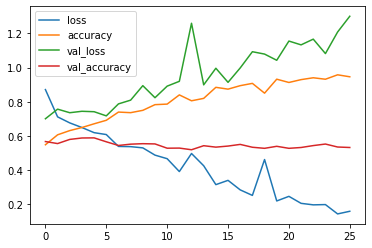

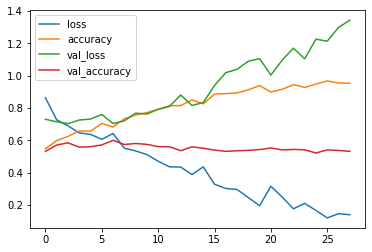

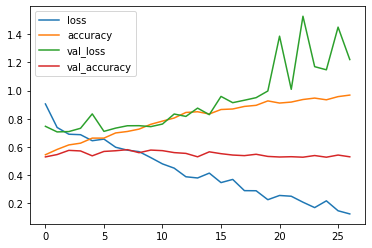

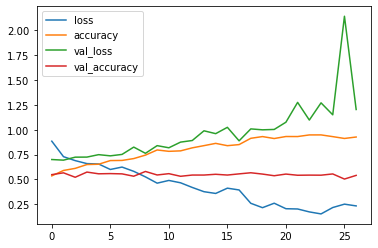

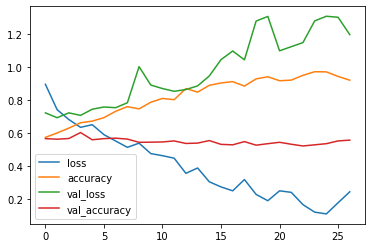

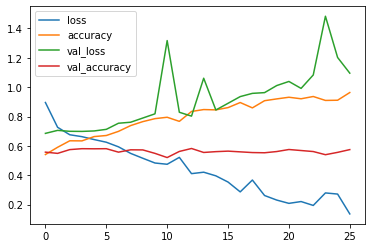

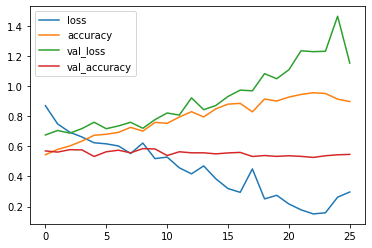

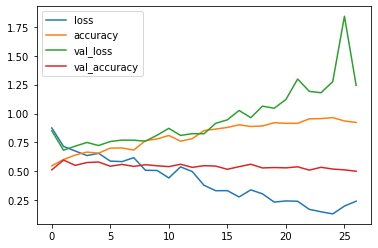

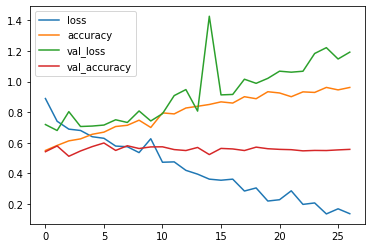

In [23]:
####Loop to train models 10 times and get best model#####
best_accuracy = 0
accuracies = []
for session in range(10):
    shallow = True

    ####  MODEL BUILDER  ####
    
    model = tuner.hypermodel.build(best_hps)  #build new model with best hyperparameters
    model.summary()
    model.fit(x_train,y_cat_train, epochs = 400, validation_data=(x_test,y_cat_test), callbacks = [early_stop], verbose=2)
    
    metrics = pd.DataFrame(model.history.history)
    metrics.plot()

    predictions = model.predict_classes(x_test)

    print(classification_report(y_test,predictions, target_names=labels))

    print(confusion_matrix(y_test,predictions))
    
    perf = model.evaluate(x_test, y_cat_test)
    accuracies.append(perf[1])
    if perf[1] > best_accuracy:
        best_accuracy = perf[1]
        best_model = model
    

In [24]:
#accuracy for best performing model
best_accuracy

0.5975017547607422

In [25]:
#classification report and confusion matrix for best model
best_predictions = best_model.predict_classes(x_test)

print(classification_report(y_test,best_predictions, target_names=labels, digits =3))
conf = confusion_matrix(y_test,best_predictions)
print(conf)

              precision    recall  f1-score   support

   Left Hand      0.584     0.678     0.628       721
  Right Hand      0.616     0.517     0.562       720

    accuracy                          0.598      1441
   macro avg      0.600     0.597     0.595      1441
weighted avg      0.600     0.598     0.595      1441

[[489 232]
 [348 372]]


In [26]:
best_model.evaluate(x_test, y_cat_test)

46/46 [==============================] - 0s 5ms/step - loss: 0.6829 - accuracy: 0.5975


[0.6828622817993164, 0.5975017547607422]

In [27]:
#Classification accuracies of the 10 models trained
accuracies

[0.5746009945869446,
 0.5676613450050354,
 0.5843164324760437,
 0.5454545617103577,
 0.5669673681259155,
 0.562109649181366,
 0.5572519302368164,
 0.5697432160377502,
 0.5975017547607422,
 0.5794587135314941]

In [28]:
###Confusion matrix labels
group_counts = ['{0:0.0f}'.format(value) for value in
                conf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     conf.flatten()/np.sum(conf)]
conf_labels = [f'{v1}\n\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
conf_labels = np.asarray(conf_labels).reshape(conf.shape)

In [29]:
conf_labels

array([['489\n\n33.93%', '232\n\n16.10%'],
       ['348\n\n24.15%', '372\n\n25.82%']], dtype='<U11')

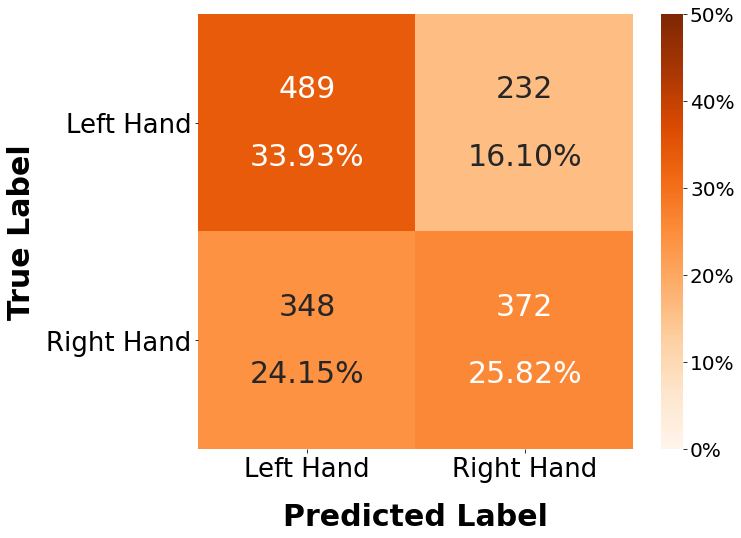

In [30]:
###Create confusion matrix from results of best model
from matplotlib.ticker import PercentFormatter
fig, ax = plt.subplots(figsize=(10,8))
confusion = sns.heatmap(conf/np.sum(conf), annot=conf_labels, annot_kws={'fontsize':30},vmin=0, vmax=1/len(labels), 
            fmt='', cmap='Oranges', xticklabels=labels,yticklabels=labels, square=True, ax=ax, cbar_kws = {'ticks':np.arange(0,1 + 1/5,1/5)/len(labels)})
confusion.set_xticklabels(labels, fontsize=26, rotation=0)
confusion.set_yticklabels(labels, fontsize=26, rotation=0)
confusion.set_ylabel('True Label', fontsize=30, labelpad=10, weight='bold')
confusion.set_xlabel('Predicted Label', fontsize=30, labelpad=20, weight='bold')
#confusion.set_title('Confusion Matrix', fontsize=22)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
plt.show()

In [32]:
#Create folder for confusion matrices if one doesn't exist
os.mkdir('Confusion Matrices')

In [31]:
#save confusion matrix for best model
fig.savefig('Confusion Matrices\\' + '2classLHRHMITuned.png', bbox_inches='tight')

In [32]:
#save best model
best_model.save('Best Models\\' + 'tuned2classLHRHMI-Active8chanfpzbias 05to20-08 train 23&24-08 test-59,8%acc.h5')